# Assignment: Linear Models
## Foundations of Machine Learning
## Do Q1 and one other question

**Q1.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented

1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood `.
2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?
3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?
4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Property Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.
7. (Optional) We've included `Neighborhood ` and `Property Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A townhouse in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they increase significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('./data/Q1_clean.csv')
df.head()

,Price,Review Scores Rating,Neighbourhood,Property Type,Room Type
0,549,96.0,Manhattan,Apartment,Private room
1,149,100.0,Brooklyn,Apartment,Entire home/apt
2,250,100.0,Manhattan,Apartment,Entire home/apt
3,90,94.0,Brooklyn,Apartment,Private room
4,270,90.0,Manhattan,Apartment,Entire home/apt


In [5]:
# Part 1
# Manhattan is the most expensive on average.
df.loc[:,['Price','Neighbourhood '] ].groupby('Neighbourhood ').describe()

Price                                                      \
                  count        mean         std   min     25%    50%    75%   
Neighbourhood                                                                 
Bronx             217.0   75.276498   39.755468  10.0   50.00   60.0   90.0   
Brooklyn         8487.0  127.747378  106.038466  20.0   75.00  100.0  150.0   
Manhattan       11763.0  183.664286  170.434606  25.0  103.00  150.0  214.0   
Queens           1590.0   96.857233   61.712648  25.0   60.00   80.0  115.0   
Staten Island      96.0  146.166667  508.462029  35.0   54.75   71.0   99.0   

                         
                    max  
Neighbourhood            
Bronx             244.0  
Brooklyn         4500.0  
Manhattan       10000.0  
Queens            950.0  
Staten Island    5000.0

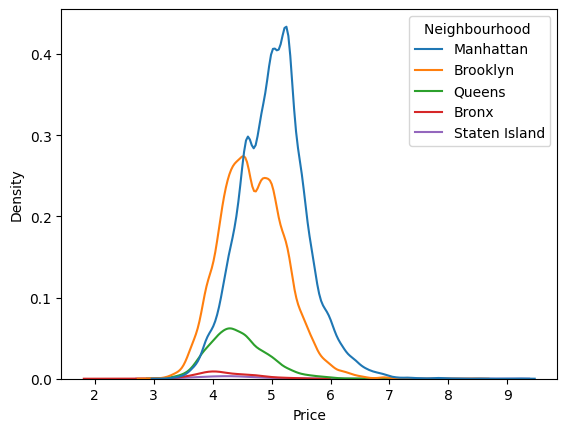

In [4]:
sns.kdeplot(x=np.log(df['Price']), hue=df['Neighbourhood '])
plt.show()

In [6]:
# Part 2
# The coefficients in the regression are the same as the means in the table from part 1.
y = df['Price']
X = pd.get_dummies(df['Neighbourhood '], dtype='int')

from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=False).fit(X,y)

results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
results

,variable,coefficient
0,Bronx,75.276498
1,Brooklyn,127.747378
2,Manhattan,183.664286
3,Queens,96.857233
4,Staten Island,146.166667


In [7]:
# Part 3
# By excluding the Bronx in the dummy encoding, it serves as the reference group, with its previous regression coefficient now represented by the intercept.
# The coefficients in this regression model indicate the relative difference in average prices compared to the Bronx. To retrieve the absolute average prices
# of the neighborhoods from the initial regression, add each neighborhood's coefficient to the intercept.
y = df['Price']
X = pd.get_dummies(df['Neighbourhood '], dtype='int', drop_first = True)

from sklearn import linear_model
reg = linear_model.LinearRegression().fit(X,y)

results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
results

,variable,coefficient
0,Brooklyn,52.470881
1,Manhattan,108.387789
2,Queens,21.580735
3,Staten Island,70.890169


In [8]:
# Part 4
# The R^2 on the test set is 0.067, and the RMSE is 125.01. The coefficient for "Review Scores Rating" is 1.032.
# Based on the coefficients, Manhattan is the most expensive neighborhood to rent a property.
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y = df['Price']
X = df.loc[:,['Review Scores Rating', 'Neighbourhood '] ]
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=.2,
                                                    random_state=100)

Z_train = pd.concat([X_train['Review Scores Rating'],
                     pd.get_dummies(X_train['Neighbourhood '], dtype='int')], axis = 1)
Z_test = pd.concat([X_test['Review Scores Rating'],
                    pd.get_dummies(X_test['Neighbourhood '], dtype='int')], axis = 1)

reg = linear_model.LinearRegression(fit_intercept=False).fit(Z_train,y_train)

y_hat = reg.predict(Z_test)
print('Rsq: ', reg.score(Z_test,y_test))
rmse = np.sqrt( np.mean( (y_test - y_hat)**2 ))
print('RMSE: ', rmse)

results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
results

Rsq:  0.06701086106947296
RMSE:  125.01092061382933


,variable,coefficient
0,Review Scores Rating,1.032257
1,Bronx,-17.261392
2,Brooklyn,32.180888
3,Manhattan,89.421020
4,Queens,4.050208
5,Staten Island,61.576393


In [9]:
# Part 5
# The R^2 on the test set is 0.220, and the RMSE is 114.28. The coefficient for "Review Scores Rating" is 0.627.
# The most expensive kind of property to rent is an "Entire home/apt," with a coefficient of 110.618.
y = df['Price']
X = df.loc[:,['Review Scores Rating', 'Neighbourhood ', 'Room Type'] ]
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=.2,
                                                    random_state=100)

Z_train = pd.concat([X_train['Review Scores Rating'],
                    pd.get_dummies(X_train['Neighbourhood '], dtype='int'),
                    pd.get_dummies(X_train['Room Type'], dtype='int')],
                    axis = 1)
Z_test = pd.concat([X_test['Review Scores Rating'],
                    pd.get_dummies(X_test['Neighbourhood '], dtype='int'),
                    pd.get_dummies(X_test['Room Type'], dtype='int')],
                    axis = 1)
reg = linear_model.LinearRegression(fit_intercept=False).fit(Z_train,y_train)
y_hat = reg.predict(Z_test)
print('Rsq: ', reg.score(Z_test,y_test))
rmse = np.sqrt( np.mean( (y_test - y_hat)**2 ))
print('RMSE: ', rmse)
results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
results

Rsq:  0.22035348129282306
RMSE:  114.27692123130633


,variable,coefficient
0,Review Scores Rating,0.626912
1,Bronx,-13.022765
2,Brooklyn,10.378456
3,Manhattan,53.693304
4,Queens,-6.833330
5,Staten Island,50.003022
6,Entire home/apt,110.617820
7,Private room,3.101341
8,Shared room,-19.500474


In [ ]:
# Part 6
# The change in the coefficient for "Review Scores Rating" from part 4 to 5 suggests that, when "Room Type" is included in the model, the impact of "Review Scores Rating"
# on price is adjusted to account for the variation in price that can be attributed to differences in "Room Type."

**Q2.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

**Q3.** This is a question about linear regression. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running the following regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q4.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{alignat*}{3}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{alignat*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{alignat*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{alignat*}

which can be written in terms of sample covariance and sample variance as:

\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{alignat*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)

**Q5.**
1. Find a dataset on a topic you're interested in. Some easy options are data.gov, kaggle.com, and data.world.
2. Clean the data and do some exploratory data analysis on key variables that interest you. Pick a particular target/outcome variable and features/predictors.
3. Split the sample into an ~80% training set and a ~20% test set.
4. Run a few regressions of your target/outcome variable on a variety of features/predictors. Compute the SSE on the test set.
5. Which model performed the best, and why?
6. What did you learn?